In [68]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sqlite3 as sql
import math
import scipy.optimize as optimize

a4_dims = (11.7, 8.27)

In [69]:
def fetch_axes(db_conn, query, *args):
    return list(zip(*db_conn.cursor().execute(query,args)))

# Distribution of $\frac{h}{h_{max}}$ of failed and succeeded search runs.

In [70]:
query_failed = """
SELECT entropy
FROM search_run
WHERE last_unsat > 0
"""

query_succeeded = """
SELECT entropy
FROM search_run
WHERE last_unsat = 0
"""

bins = np.arange(0.6,1.0,0.0025)

def get_entropy_dist(file):
    with sql.connect(file) as conn:
        failures, = fetch_axes(conn, query_failed)
        successes, = fetch_axes(conn, query_succeeded)
        return failures, successes
    
def plot_dist(failures, successes):
    fix, ax = plt.subplots(figsize=a4_dims)
    sns.distplot(failures, ax = ax, label='failed runs', axlabel='Entropy', bins=bins);
    sns.distplot(successes, ax = ax, label='succeeded runs', axlabel='Entropy', bins=bins);
    ax.legend();
    ax.grid();
    return ax
    
def plot_entropy_dist(file):
    fs, ss = get_entropy_dist(file)
    return plot_dist(fs, ss)

## Concerning $k = 3$, $v = 500$, $r = 4.1$

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


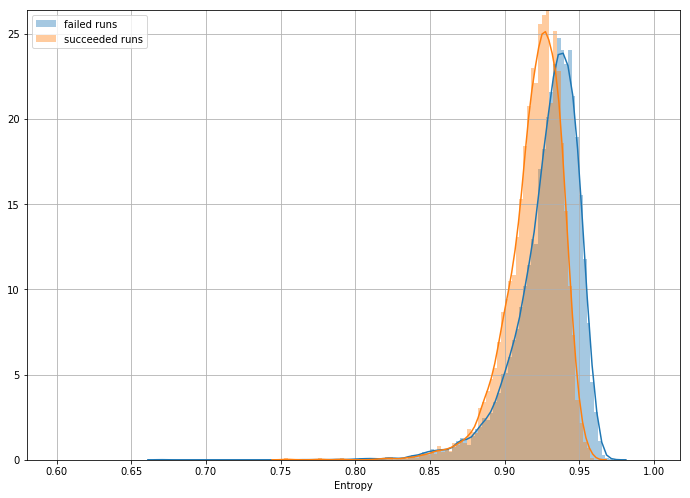

In [71]:
plot_entropy_dist('data/k3-v500-r4.1.raw.db');

## Concerning $k = 3$, $v = 500$, $r = 4.2$

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


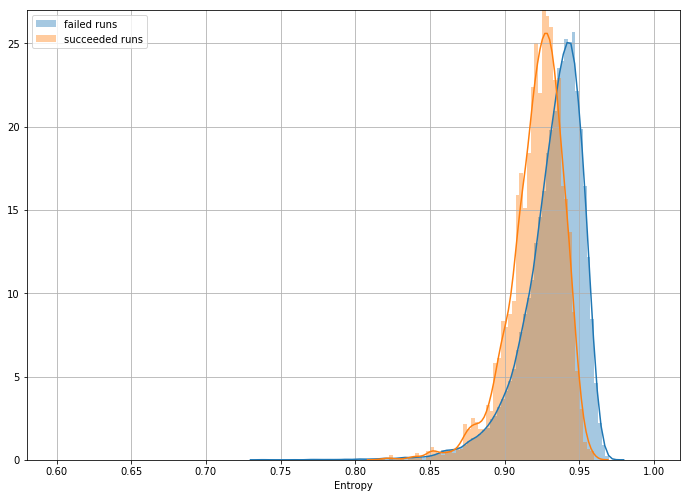

In [72]:
plot_entropy_dist('data/k3-v500-r4.2.raw.db');

# Concerning early restarts

Failure: alpha = 159.91613572218276, beta = 11.577035178715022
Success: alpha = 151.54587157441972, beta = 13.014752164275217


/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


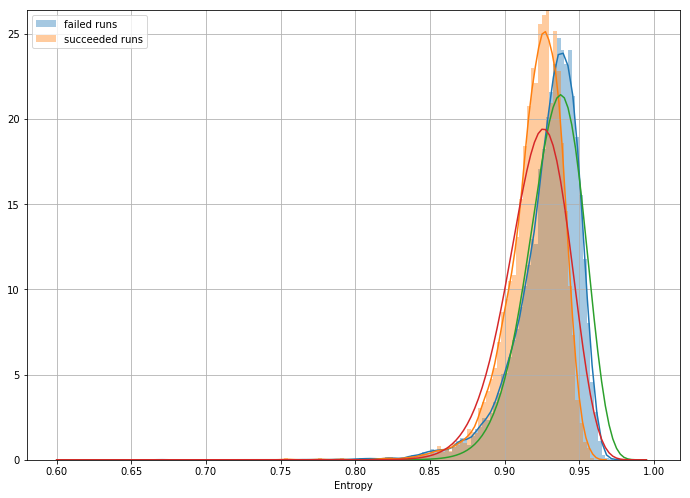

In [73]:


def squared_error(f, xs, ys):
    squared_errors = np.vectorize(lambda y1, y2: pow(y1-y2, 2))
    f1 = np.vectorize(f)
    return sum(squared_errors(f1(xs),ys))

def beta_pdf(p,q):
    def B(p,q):
        return math.gamma(p) * math.gamma(q) / math.gamma(p + q)
    return lambda x: x ** (p - 1) * (1 - x) ** (q - 1) / B(p,q)

def partial_difference_quotient(f, i, vs, dx = 0.00001):
    vs1 = np.array([v_j + (dx if j == i else 0) for j, v_j in enumerate(vs)])
    # fv = np.vectorize(f)
    return (f(*vs1) - f(*vs))/dx

def estimate_gradient(f, vs, dx=0.00001):
    f1 = np.vectorize(lambda i: partial_difference_quotient(f, i, vs, dx))
    idxs = np.arange(0,len(vs),dtype=int)
    return f1(idxs)

def safe(f):
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f

def step(vs, directions, step_size):
    return np.vectorize(lambda v, d: v + step_size * d)(vs, directions)

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=10):
    step_sizes = [0.001,0.0001,0.00001/2]
    target_fn = safe(target_fn)
    gradient_fn = safe(gradient_fn)
    theta = theta_0
    value = target_fn(*theta)
    
    while True:
        gradient = gradient_fn(*theta)
        next_thetas = np.array([step(theta, gradient, -step_size) for step_size in step_sizes])
        next_theta = min(next_thetas, key = lambda th: target_fn(*th))
        next_value = target_fn(*next_theta)
        err = abs(value-next_value)
        if math.isnan(err):
            raise Exception("nan")
        if err < tolerance or math.isnan(err):
            return theta
        else:
            theta, value = next_theta, next_value

            
            
fs, ss = get_entropy_dist('data/k3-v500-r4.1.raw.db')

count_failure, bins_failure = np.histogram(fs, bins=bins)
bins_failure = bins_failure[:-1]

err_failure = lambda p,q: squared_error(beta_pdf(p,q), bins_failure, count_failure)  

alpha_f, beta_f = minimize_batch(
    err_failure,
    lambda p, q: estimate_gradient(err_failure, [p,q]),
    np.random.uniform(0,2,2),
)

print("Failure: alpha = {}, beta = {}".format(alpha_f, beta_f))

count_success, bins_success = np.histogram(ss, bins=bins)
bins_success = bins_success[:-1]
err_success = lambda p,q: squared_error(beta_pdf(p,q), bins_success, count_success)
alpha_s, beta_s = minimize_batch(
    err_success,
    lambda p, q: estimate_gradient(err_success, [p,q]),
    np.random.uniform(0,2,2),
)

print("Success: alpha = {}, beta = {}".format(alpha_s, beta_s))

a = plot_entropy_dist('data/k3-v500-r4.1.raw.db');
a.plot(bins_failure, np.vectorize(beta_pdf(alpha_f,beta_f))(bins_failure))
a.plot(bins_success, np.vectorize(beta_pdf(alpha_s,beta_s))(bins_success))

# Concerning $k = 3$, $v = 500$, $r = 4.1$ with early restarts

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


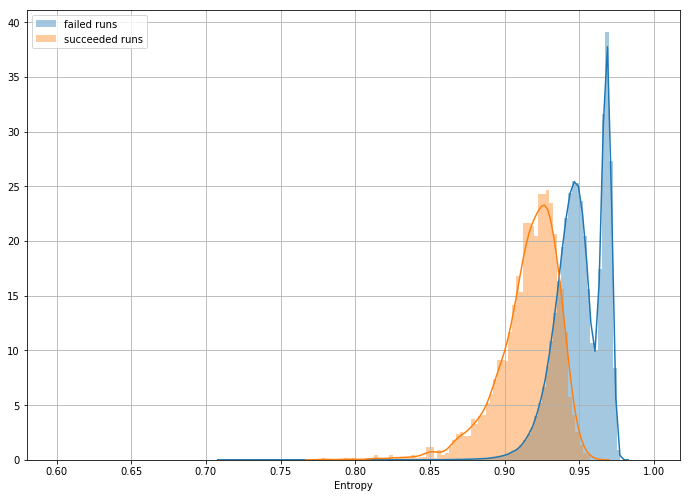

In [74]:
plot_entropy_dist('data/k3-v500-r4.1-er.raw.db');

# Concerning $k = 3$, $v = 500$, $r = 4.2$ with early restarts

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


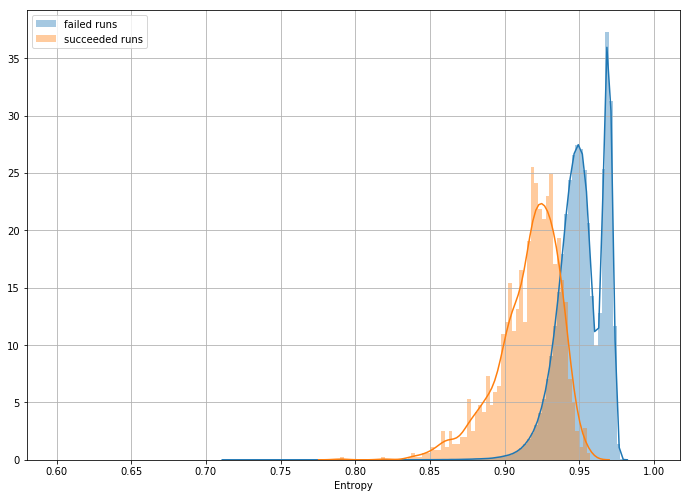

In [75]:
plot_entropy_dist('data/k3-v500-r4.2-er.raw.db');